# Data preparation

In [ ]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

## 1. Load raw data

In [2]:
calories=pd.read_csv('../data/raw/calories.csv')
exercise=pd.read_csv('../data/raw/exercise.csv')

print(calories.head())
print(exercise.head())

    User_ID  Calories
0  14733363     231.0
1  14861698      66.0
2  11179863      26.0
3  16180408      71.0
4  17771927      35.0
    User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  14733363    male   68   190.0    94.0      29.0       105.0       40.8
1  14861698  female   20   166.0    60.0      14.0        94.0       40.3
2  11179863    male   69   179.0    79.0       5.0        88.0       38.7
3  16180408  female   34   179.0    71.0      13.0       100.0       40.5
4  17771927  female   27   154.0    58.0      10.0        81.0       39.8


In [3]:
# Merge datasets on 'User_ID'
newData_df = pd.merge(calories, exercise, on='User_ID', how='inner')  # Using inner join

# Preview merged data
print(newData_df.head())

# Save merged dataset
newData_df.to_csv('../data/raw/mergedNew_data.csv', index=False)

    User_ID  Calories  Gender  Age  Height  Weight  Duration  Heart_Rate  \
0  14733363     231.0    male   68   190.0    94.0      29.0       105.0   
1  14861698      66.0  female   20   166.0    60.0      14.0        94.0   
2  11179863      26.0    male   69   179.0    79.0       5.0        88.0   
3  16180408      71.0  female   34   179.0    71.0      13.0       100.0   
4  17771927      35.0  female   27   154.0    58.0      10.0        81.0   

   Body_Temp  
0       40.8  
1       40.3  
2       38.7  
3       40.5  
4       39.8  


## 2. Select features

In [4]:
newData_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Calories    15000 non-null  float64
 2   Gender      15000 non-null  object 
 3   Age         15000 non-null  int64  
 4   Height      15000 non-null  float64
 5   Weight      15000 non-null  float64
 6   Duration    15000 non-null  float64
 7   Heart_Rate  15000 non-null  float64
 8   Body_Temp   15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


Given some self-report biometrics from the user we will build two models that do the following depending on user input:

1. Take workout duration and predict calorie burn for each workout type (i.e. 'I am going to work out for X minutes, how many calories will I burn?').
2. Take calorie burn and predict duration for each workout type (i.e., 'I want to burn X calories, how long do I need to work out for?').

Both models will share a set of input 'biometric' features. These must be things the user is likely to know about themselves. People probably know their weight and age, but probably don't know their VO2 max.

The models will differ in one of their input features and their output:

1. `calorie_model` needs to take workout duration + biometrics as input features and predict calories burned.
2. `time_model` needs to take calories burned + biometrics as input features and predict workout duration. 

We will use dictionaries to keep everything organized

In [5]:
biometric_features=[
    'Age', 'Gender', 'Height', 'Weight'
]

input_features={
    'calorie_model': ['Duration'] + biometric_features,
    'time_model': ['Calories Burned'] + biometric_features
}

output_features={
    'calorie_model': 'Calories',
    'time_model': 'Duration'
}

## 3. Encode categorical features

In [6]:
# Your code here... I recommend sklearn's OrdinalEncoder to start with because it will let us keep the 
# number/names of features constant. We can experiment with improving encoding later if we have time.

categorical_features=['Gender']

# Extract unique values from categorical features
categories_list = [
    newData_df["Gender"].unique().tolist(),
]

# Apply dynamic categories to OrdinalEncoder
encoder = OrdinalEncoder(categories=categories_list)

# Apply encoding to categorical columns
df_encoded = newData_df.copy()  # Keep original dataframe
df_encoded[categorical_features] = encoder.fit_transform(newData_df[categorical_features])

print(df_encoded.head())  # Check encoded values

    User_ID  Calories  Gender  Age  Height  Weight  Duration  Heart_Rate  \
0  14733363     231.0     0.0   68   190.0    94.0      29.0       105.0   
1  14861698      66.0     1.0   20   166.0    60.0      14.0        94.0   
2  11179863      26.0     0.0   69   179.0    79.0       5.0        88.0   
3  16180408      71.0     1.0   34   179.0    71.0      13.0       100.0   
4  17771927      35.0     1.0   27   154.0    58.0      10.0        81.0   

   Body_Temp  
0       40.8  
1       40.3  
2       38.7  
3       40.5  
4       39.8  


## 4. Train-test split

In [7]:
# Your code here....
def split_data(df, test_size=0.2, random_state=42):
    """Splits the dataset into train_df and test_df."""
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    return train_df, test_df

# Apply the split
train_df, test_df = split_data(df_encoded)

# Confirm the split sizes
print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

Train Data Shape: (12000, 9)
Test Data Shape: (3000, 9)


In [8]:
target_col = 'Calories'
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
print(X_train.shape)
print(y_train.shape)

(11250, 8)
(11250,)


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)

print(f'R² of gradient boosting model: {r2:.4f}')

R² of gradient boosting model: 0.9970


In [11]:

scores=cross_val_score(
    model,
    X_train,
    y_train,
    cv=7,
    n_jobs=-1
)


print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f}% +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 99.6% +/- 0.0%


In [12]:
hyperparameters={
    'n_estimators':[200, 300],
    'criterion':['friedman_mse', 'squared_error'],
    'max_depth':[4,8],
    'min_samples_split':[2,4,8],
    'min_weight_fraction_leaf':[0.001,0.01,0.1],
    'max_features':[0.25,0.5],
    'ccp_alpha':[0.001,0.01],
}

search=GridSearchCV(
    model,
    hyperparameters,
    return_train_score=True,
    cv=3,
    n_jobs=-1
)

search_results=search.fit(X_train, y_train)
model=search_results.best_estimator_
hyperparameters=search_results.best_params_

print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()

Best hyperparameters:

 ccp_alpha: 0.001
 criterion: friedman_mse
 max_depth: 4
 max_features: 0.5
 min_samples_split: 2
 min_weight_fraction_leaf: 0.001
 n_estimators: 300



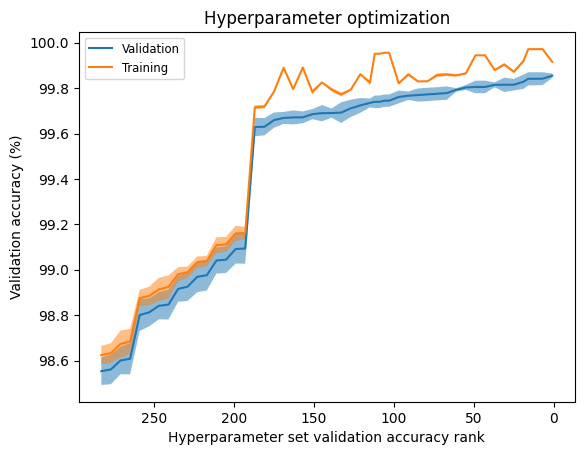

In [13]:
import function as funcs
funcs.plot_cross_validation(search_results)

In [14]:
from sklearn.metrics import mean_squared_error, r2_score


model = GradientBoostingRegressor(**hyperparameters, random_state=42)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R² score: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

R² score: 0.9988
Root Mean Squared Error: 2.2095


### Now going to train Model for Duration to be the output

In [15]:
target_col = 'Duration'
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)

print(f'R² of gradient boosting model: {r2:.4f}')

R² of gradient boosting model: 0.9889


In [17]:

scores=cross_val_score(
    model,
    X_train,
    y_train,
    cv=7,
    n_jobs=-1
)


print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f}% +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 98.8% +/- 0.0%


In [18]:
hyperparameters={
    'n_estimators':[200, 300],
    'criterion':['friedman_mse', 'squared_error'],
    'max_depth':[4,8],
    'min_samples_split':[2,4,8],
    'min_weight_fraction_leaf':[0.001,0.01,0.1],
    'max_features':[0.25,0.5],
    'ccp_alpha':[0.001,0.01],
}

search=GridSearchCV(
    model,
    hyperparameters,
    return_train_score=True,
    cv=3,
    n_jobs=-1
)

search_results=search.fit(X_train, y_train)
model=search_results.best_estimator_
hyperparameters=search_results.best_params_

print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()

Best hyperparameters:

 ccp_alpha: 0.001
 criterion: friedman_mse
 max_depth: 4
 max_features: 0.5
 min_samples_split: 2
 min_weight_fraction_leaf: 0.001
 n_estimators: 300



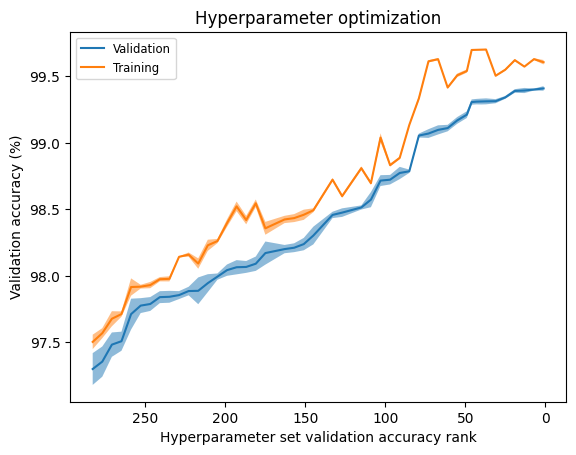

In [19]:
import function as funcs
funcs.plot_cross_validation(search_results)

In [20]:
from sklearn.metrics import mean_squared_error, r2_score


model = GradientBoostingRegressor(**hyperparameters, random_state=42)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R² score: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

R² score: 0.9946
Root Mean Squared Error: 0.6131


## 5. Save assets

In [24]:
# Feature information
with open('../data/biometric_features.pkl', 'wb') as output_file:
    pickle.dump(biometric_features, output_file)

with open('../data/input_features.pkl', 'wb') as output_file:
    pickle.dump(input_features, output_file)

with open('../data/output_features.pkl', 'wb') as output_file:
    pickle.dump(output_features, output_file)

with open('../data/categorical_features.pkl', 'wb') as output_file:
    pickle.dump(categorical_features, output_file)

# Data
Path('../data/processed').mkdir(exist_ok=True)

with open('../data/processed/all.pkl', 'wb') as output_file:
    pickle.dump(newData_df, output_file)

with open('../data/processed/train.pkl', 'wb') as output_file:
    pickle.dump(train_df, output_file)

with open('../data/processed/test.pkl', 'wb') as output_file:
    pickle.dump(test_df, output_file)

# Optimized hyperparameters
with open('../data/processed/hyperparameters.pkl', 'wb' ) as input_file:
    pickle.dump(hyperparameters, input_file) 
